This notebook aims at retrieving documents relevant for the example use case. <br>
Usage of Corex based on following tutorial: https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

In [58]:
import pandas as pd
import sklearn
from langdetect import detect
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import seaborn as sns
import corextopic.corextopic as ct
import corextopic.vis_topic as vt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline


##I. Prepare dataset

In [8]:
# path to csv dataset created with dataset_preparation.ipynb
df = pd.read_csv(' ')

In [12]:
df['language'] = df['texts'].apply(lambda x: detect(x))

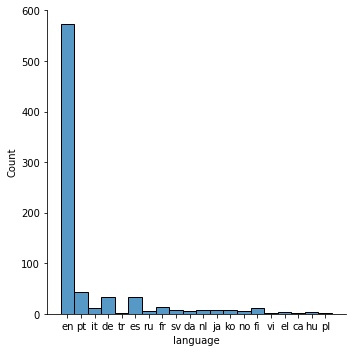

In [13]:
sns.displot(df, x="language", discrete=True)

Keep texts in English only

In [14]:
df = df[df['language'] == 'en']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 778
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   archive_links    573 non-null    object
 1   urls             573 non-null    object
 2   record_ids       570 non-null    object
 3   content_lengths  573 non-null    int64 
 4   warc_dates       573 non-null    object
 5   html_metadata    569 non-null    object
 6   texts            573 non-null    object
 7   language         573 non-null    object
dtypes: int64(1), object(7)
memory usage: 40.3+ KB


##II. Texts pre-processing

In [30]:
vectorizer = CountVectorizer(stop_words='english', max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(df['texts'])
doc_word = ss.csr_matrix(doc_word)

#nr of documents, nr of words
doc_word.shape 

(573, 20000)

In [32]:
words = list(np.asarray(vectorizer.get_feature_names_out()))


In [33]:
# remove words that are numbers
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

# number of documents / nr of words
doc_word.shape

(573, 17720)

## III. Model training

In [34]:
# training with 10 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [38]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: retail, entertainment, health, travel, doctors, engineers, towns, photography, regulations, waste
1: markets, funds, investments, fund, loss, assets, volatility, research, securities, products
2: america, investors, korea, portugal, capital, solutions, belgium, africa, investment, china
3: machine, makers, stars, rocket, electricity, foundation, jeff, hollywood, bob, east
4: sports, cars, login, hotels, deals, fashion, assembly, tourism, music, books
5: ventnor, wa, yearly, esc, perth, pixels, captured, presentations, pixadmin, announcements
6: states, united, etfs, return, principal, net, date, advisors, type, expenses
7: black, policy, netherlands, ishares, terms, poland, spain, listed, singapore, select
8: stop, awards, links, facebook, box, share, park, city, arts, green
9: kids, campaign, clubs, free, child, women, bible, stories, peace, vision


In [39]:
# most probable documents by topic (for first topic)
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(458, 0.0),
 (323, 0.0),
 (516, 0.0),
 (517, 0.0),
 (64, 0.0),
 (313, 0.0),
 (61, 0.0),
 (524, 0.0),
 (476, 0.0),
 (530, 0.0)]

In [40]:
# total correlation
topic_model.tc


333.0312724936404

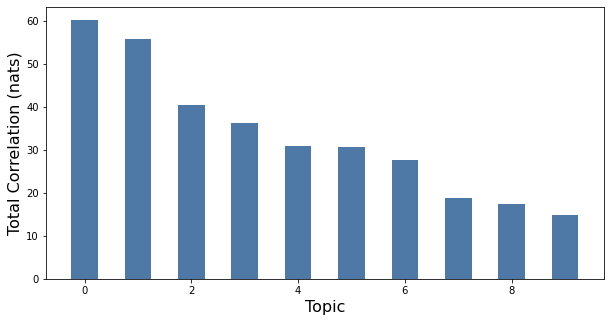

In [41]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## IV. Anchored topic models 

In [45]:
anchor_words = [['larry','fink','ceo','blackrock','letter'],['finance','investment','etf']]

In [57]:
anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [47]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: blackrock, fink, larry, ceo, money, company, assets, loss, capital, research
1: investment, etf, finance, italy, states, france, markets, portugal, brazil, ishares


#### Per topic correlation score

In [52]:
print(np.mean(anchored_topic_model.log_z, axis=0))
print(anchored_topic_model.tcs)

[72.79792572 39.84738616 48.95158613 15.85926739 13.42708678  7.96979507
 28.51900498 25.67557543 45.9428479  23.54609754]
[72.79792572 39.84738616 48.95158613 15.85926739 13.42708678  7.96979507
 28.51900498 25.67557543 45.9428479  23.54609754]


## VI. Documents display

In [55]:
anchored_topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(0, 0.0),
 (264, 0.0),
 (268, 0.0),
 (269, 0.0),
 (279, 0.0),
 (289, 0.0),
 (290, 0.0),
 (297, 0.0),
 (300, 0.0),
 (304, 0.0)]

In [56]:
anchored_topic_model.get_top_docs(topic=1, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(0, 0.0),
 (251, 0.0),
 (256, 0.0),
 (257, 0.0),
 (260, 0.0),
 (268, 0.0),
 (269, 0.0),
 (271, 0.0),
 (274, 0.0),
 (279, 0.0)]